## Creating a Normalized Difference Vegetation Index (NDVI) Cloud Optimized GeoTIFF (COG)

In this example, we will walk through steps for searching MAAP and accessing data, processing data (specifically NDVI from Landsat), and saving the data as a COG.

We begin with a shell command (`!`) for installing `rasterio` to read and write geospatial raster data. We also install `rio-cogeo`, a plugin for RasterIO for COG creation and validation.

In [1]:
# install the rasterio and rio-cogeo packages
!pip install rasterio rio-cogeo --quiet

We utilize the `%pylab inline` magic function to work with Matplotlib figures. We then import the `os`, `tarfile`, and `rasterio` modules, import the `MAAP` package, and create a new MAAP class.

In [2]:
# magic function for pylab inline
%pylab inline

# import required modules
import os
import tarfile
import rasterio

from rasterio.io import MemoryFile
from rasterio.transform import from_bounds

from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles

# import the MAAP package
from maap.maap import MAAP

# create MAAP class
maap = MAAP()

Populating the interactive namespace from numpy and matplotlib


For this example, the Collection Concept ID is used to search for Landsat 8 Operational Land Imager (OLI) Surface Reflectance Analysis Ready Data granules. For more information about searching for granules in MAAP, please see https://maap-project.readthedocs.io/en/latest/search/granules.html.

In [3]:
# assigning Landsat 8 Surface Reflectance product Collection Concept ID
LANDSATID = 'C1200110769-NASA_MAAP'

# search for granules with Collection Concept ID 
results = maap.searchGranule(concept_id=LANDSATID)

We assign a variable (in this case, `scene`) to the first result of our search from the cell above.

In [4]:
# grab first result
scene = results[0]

A data directory is then set and if the directory does not already exist, it is created. The scene from our search is then downloaded into the file system at this directory. Here, the function `getLocalPath()` is accessing the data stored on the MAAP's S3 storage bucket and downloading it directly to the path provided.

In [5]:
# set data directory
dataDir = './data'

# check if directory exists -> if directory doesn't exist, directory is created
if not os.path.exists(dataDir):
    os.mkdir(dataDir)

# downloading scene from search into data directory
data = scene.getLocalPath(dataDir)
data

'./data/LC081850582013041201T1-SC20190602105855.tar.gz'

Now we can see that the data directory has been created and the Landsat scene is downloaded into the directory.

We then assign an output directory for the Landsat 8 files to a variable (`sceneDir`) using the name of the Landsat 8 granule. Since the data are in tar.gz files, we extract them. The extracted files are then placed into the specified output directory.

In [6]:
# getting ouput directory for landsat files
sceneDir,_ = os.path.splitext(os.path.splitext(data)[0])

# extracting landsat files into directory
with tarfile.open(data, "r:gz") as tar:
    tar.extractall(path = sceneDir)

Next, we create a list of the Landsat 8 files in our output directory. 

In [7]:
# getting list of landsat files
flist = os.listdir(sceneDir)
flist

['LC08_L1TP_185058_20130412_20170505_01_T1_radsat_qa.tif',
 'LC08_L1TP_185058_20130412_20170505_01_T1_sr_band1.tif',
 'LC08_L1TP_185058_20130412_20170505_01_T1_sr_band2.tif',
 'LC08_L1TP_185058_20130412_20170505_01_T1_sr_band5.tif',
 'LC08_L1TP_185058_20130412_20170505_01_T1_sr_band7.tif',
 'LC08_L1TP_185058_20130412_20170505_01_T1_MTL.txt',
 'LC08_L1TP_185058_20130412_20170505_01_T1_sr_aerosol.tif',
 'LC08_L1TP_185058_20130412_20170505_01_T1_sr_band4.tif',
 'LC08_L1TP_185058_20130412_20170505_01_T1.xml',
 'LC08_L1TP_185058_20130412_20170505_01_T1_sr_band6.tif',
 'LC08_L1TP_185058_20130412_20170505_01_T1_pixel_qa.tif',
 'LC08_L1TP_185058_20130412_20170505_01_T1_ANG.txt',
 'LC08_L1TP_185058_20130412_20170505_01_T1_sr_band3.tif']

We then set variables to the paths of the files for band 4 and band 5 from the list we created by searching through all of the paths and extracting out the file paths that meet our criteria (in this case band 4 and band 5).

In [8]:
# reading through each file and checking if it is band 4 or band 5 and then getting those paths
band4 = [os.path.join(sceneDir,f) for f in flist if 'band4' in f][0]
band5 = [os.path.join(sceneDir,f) for f in flist if 'band5' in f][0]

`rasterio` is used to open the band 4 and band 5 GeoTIFFs. These GeoTIFFs are then read as NumPy arrays and the "no data" value for the arrays is specified. We are specifying the "no data" so that we can later assign a specific "no data" value after processing.

In [9]:
# using rasterio to open GeoTIFFs
nir_ds = rasterio.open(band5)
red_ds = rasterio.open(band4)

# reading GeoTIFFs as NumPy arrays    
nir = nir_ds.read(1)
red = red_ds.read(1)

# specifying "no data" value for the arrays
inNoData = -9999

The NumPy arrays we created from our band 4 and band 5 GeoTIFFs are then used to calculate the NDVI, which we scale between -10000 to 10000 integer values. The created NDVI is converted to a signed 16-bit integer to help with processing. Because of this conversion, we assign a new "no data" value based on signed 16-bit integer values before conversion.

In [10]:
# calculate NDVI and scale between -10000 to 10000
ndvi = ((nir-red)/(nir+red)) * 10000

outNoData = -32768 
ndvi[nir == inNoData] = outNoData 

# convert to signed 16-bit integer
ndvi = (ndvi).astype(np.int16)

To inspect our NDVI image, we can create a figure and plot the NDVI values.

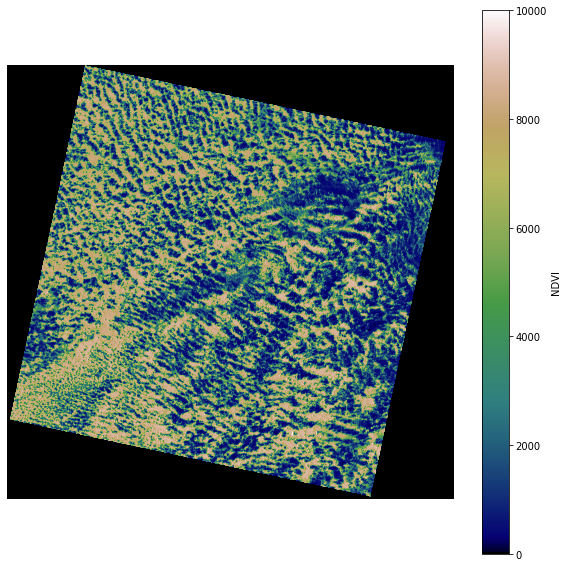

In [11]:
# creating a figure and plotting ndvi image
fig,ax = plt.subplots(figsize=(10,10))
cm = ax.imshow(ndvi,vmin = 0,vmax = 10000,cmap = 'gist_earth')
ax.axis('off')
cb = fig.colorbar(cm)
cb.set_label('NDVI')
plt.show()

The picture above shows the image for our NDVI, displaying values between 0 and 10000.

Before writing a COG, we have to specify some information for the data structure. We do this by creating a dictionary with some parameters. Specifically, in this case we will specify a compression level and our tile sizes.

In [12]:
# Get the rio-cogeo profile for deflate compression, modify some of the options
dst_profile = cog_profiles.get("deflate")
dst_profile['blockxsize']=256
dst_profile['blockysize']=256
dst_profile['predictor']=2
dst_profile['zlevel']=7
print(dst_profile)


{'driver': 'GTiff', 'interleave': 'pixel', 'tiled': True, 'blockxsize': 256, 'blockysize': 256, 'compress': 'DEFLATE', 'predictor': 2, 'zlevel': 7}


Now that we have our structure of the COG, we can begin writing to disc. We do this by first creating an in-memory GeoTIFF and then translating the GeoTIFF to a COG with our specified structure.

In [13]:
# This takes the NumPy array and writes it to a COG with good compression 

# Specify GeoTIFF structure
src_profile = dict(
    driver="GTiff",
    height=ndvi.shape[0],
    width=ndvi.shape[1],
    count=1,
    dtype=ndvi.dtype,
    crs=nir_ds.crs,
    transform=nir_ds.transform,
    nodata=outNoData,
)

# output COG path
cogOutput = "./data/ndvi_cog_example.tif"

# open memory file, write file to memory and translate to COG
with MemoryFile() as memfile:
    with memfile.open(**src_profile) as mem:
        # Populate the input file with NumPy array
        mem.write(ndvi, 1)
              
        cog_translate(
            mem,
            cogOutput,
            dst_profile,
            in_memory=True,
            quiet=True,
        )

Run the following code to validate that the created file is a COG.

In [14]:
# validate that it is a COG
!rio cogeo validate {cogOutput}

/projects/data/ndvi_cog_example.tif is a valid cloud optimized GeoTIFF
